## Library import

In [1]:
import pandas as pd 
import numpy as np
import time 
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch 
# preliminaries 
import torchtext
from torchtext.legacy.data import Field, LabelField, TabularDataset, BucketIterator
# models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
# training
import torch.optim as optim
# reproducible
SEED = 42
#Torch
torch.manual_seed(SEED)
#algoritma cuda
torch.backends.cudnn.deterministic = True 

In [4]:
!nvidia-smi

Sun Mar 13 13:42:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    57W / 300W |  19642MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   45C    P0   162W / 300W |  16998MiB / 32480MiB |     91%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [5]:
torch.cuda.set_device(3)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device_idx = "cuda:3"
torch.cuda.current_device()

3

## Prepare dataset

In [11]:
userPATH ='revision_dataset/'
tweetPATH ='revision_dataset/'

In [12]:
userlvltrain = pd.read_csv(userPATH+'/userlvltrain.csv')
userlvltest = pd.read_csv(userPATH+'/userlvltest.csv')
userlvlval = pd.read_csv(userPATH+'/userlvlval.csv')

In [13]:
train_df = pd.read_csv(tweetPATH+'/train_df.csv')
test_df = pd.read_csv(tweetPATH+'/test_df.csv')
val_df = pd.read_csv(tweetPATH+'/val_df.csv')

In [16]:
tweets_xtrain_df = pd.DataFrame()
tweets_xtest_df = pd.DataFrame()
tweets_xval_df = pd.DataFrame()

tweets_xtrain_df['text'] = train_df.text.copy()
tweets_xtrain_df['label'] = train_df.Lvalue.copy()
tweets_xval_df['text'] = val_df.text.copy()
tweets_xval_df['label'] = val_df.Lvalue.copy()
tweets_xtest_df['text'] = test_df.text.copy()
tweets_xtest_df['label'] = test_df.Lvalue.copy()

In [18]:
tokenizer = Tokenizer(oov_token=True)
tokenizer.fit_on_texts(tweets_xtrain_df.text)
word_index = tokenizer.word_index

# The maximum number of words to be used. 
vocab_size = len(word_index) + 1 
# Max number of words in each tweets.  
maxlen = tweets_xtrain_df.text.str.len().max() 
# This is fixed.
embedding_size = 200
batch_size = 128

print(vocab_size, "vocab size")
print(maxlen, "max len")
print(embedding_size, "embedding dim")
print(batch_size, "batch size")

94654 vocab size
282 max len
200 embedding dim
128 batch size


In [19]:
Y_train = tweets_xtrain_df.label
Y_test = tweets_xtest_df.label
Y_valid = tweets_xval_df.label

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(userlvltrain.userLocation)
label_names = le.classes_
label_names

array(['bali dan nusa tenggara', 'jabodetabek', 'jawa barat dan banten',
       'jawa tengah dan yogyakarta', 'jawa timur', 'kalimantan',
       'maluku dan papua', 'sulawesi', 'sumatera'], dtype=object)

In [20]:
# tokenizer and padding
X_train = tokenizer.texts_to_sequences(tweets_xtrain_df.text.values)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = tokenizer.texts_to_sequences(tweets_xtest_df.text.values) 
X_test = pad_sequences(X_test, maxlen=maxlen)
X_valid = tokenizer.texts_to_sequences(tweets_xval_df.text.values) 
X_valid = pad_sequences(X_valid, maxlen=maxlen)

# Load train and test in CUDA Memory
x_train = torch.tensor(X_train, dtype=torch.long).cuda()
y_train = torch.tensor(Y_train, dtype=torch.long).cuda()
x_test = torch.tensor(X_test, dtype=torch.long).cuda() 
y_test = torch.tensor(Y_test, dtype=torch.long).cuda()
x_valid = torch.tensor(X_valid, dtype=torch.long).cuda()
y_valid = torch.tensor(Y_valid, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)
valid = torch.utils.data.TensorDataset(x_valid, y_valid)


# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

## LSTM 

In [21]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 256
        drp = 0.25
        n_classes = len(le.classes_)
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
#         self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(256, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

### LSTM training and Evaluation

In [22]:
n_epochs = 10
n_epochs_stop = 3 
epochs_no_improve = 0
early_stop = False
min_val_loss = np.Inf


lstm = BiLSTM()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, lstm.parameters()), lr=5e-3)
lstm.cuda()

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    lstm.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = lstm(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

        if avg_loss < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = avg_loss
        else:
          epochs_no_improve += 1 
        
        if epoch>3 and epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            break
        else:
            continue
        break
    if early_stop:
      break
  
    # Set model to validation configuration -Doesn't get trained here
    lstm.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_valid),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = lstm(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred, dim = 1).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==Y_valid)/len(Y_valid)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

Epoch 1/10 	 loss=1.6211 	 val_loss=1.8797  	 val_acc=0.3343  	 time=75.59s
Epoch 2/10 	 loss=1.1638 	 val_loss=2.0080  	 val_acc=0.3359  	 time=73.23s
Epoch 3/10 	 loss=0.8775 	 val_loss=2.1634  	 val_acc=0.3362  	 time=73.65s
Epoch 4/10 	 loss=0.6498 	 val_loss=2.5436  	 val_acc=0.3434  	 time=73.87s
Early stopping!


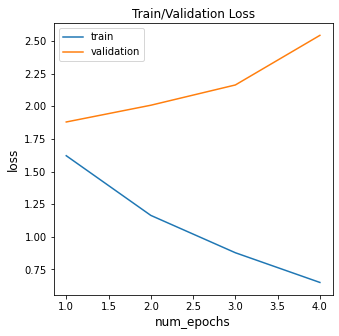

In [23]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(5,5))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(epoch)

In [24]:
torch.save(lstm.state_dict(), 'lstm-vote.pt')

In [25]:
saved_model = BiLSTM()
saved_model.load_state_dict(torch.load('lstm-vote.pt'))
saved_model.eval()
saved_model.cuda()

BiLSTM(
  (embedding): Embedding(94654, 200)
  (lstm): LSTM(200, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (out): Linear(in_features=256, out_features=9, bias=True)
)

In [26]:
#  Fungsi evaluasi
def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
      test_preds = np.zeros((len(x_test),len(le.classes_)))
      for i, (x_batch, y_batch) in enumerate(test_loader):
        y_pred = model(x_batch).detach()
        # keep/store predictions
        test_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred, dim = 1).cpu().numpy()
      test_preds = test_preds.argmax(axis=1)
      return test_preds

ypred = predict(saved_model, test_loader) 

In [27]:
pred = test_df[['screen_name']].copy()
pred['Lpredict'] = ypred
y_pred = pred.groupby(['screen_name'], sort=False).agg(lambda x:x.value_counts().index[0])

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


print('accuracy %s' % round(accuracy_score(userlvltest.Lvalue, y_pred.Lpredict),2 ))
print(classification_report(userlvltest.Lvalue, y_pred.Lpredict,target_names=label_names))

accuracy 0.46
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.89      0.31      0.46        26
               jabodetabek       0.38      0.18      0.24        28
     jawa barat dan banten       0.67      0.50      0.57        32
jawa tengah dan yogyakarta       0.76      0.44      0.56        36
                jawa timur       0.22      0.88      0.35        34
                kalimantan       0.78      0.32      0.45        22
          maluku dan papua       0.94      0.65      0.77        23
                  sulawesi       0.75      0.45      0.56        20
                  sumatera       1.00      0.34      0.51        29

                  accuracy                           0.46       250
                 macro avg       0.71      0.45      0.50       250
              weighted avg       0.69      0.46      0.49       250



In [29]:
y_pred.to_csv('lstm_result/lstm_majority_vote.csv')